# 인물사진 만들기

## [ 목차 ]   

### Step 1. 인물모드 직접 해 보기   
* 사진을 준비하자   
* 세그멘테이션으로 대상 분리하기   
* 시맨틱 세그멘테이션 다뤄보기   
* 배경 흐리게 하기   
* 흐린 배경과 원본 영상 합성   

### Step 2. 사진에서 문제점 찾기      
### Step 3. 해결 방법을 제안해 보기      

In [4]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


### Step1. 인물모드 직접 해보기

### 1. 인물

#### 사진을 준비하자

(542, 813, 3)


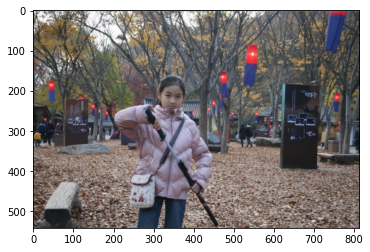

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/m_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션으로 대상 분리하기

* 시맨틱 세그멘테이션은 '사람' 등 추상적인 정보를 이미지에서 추출해 내는 방법. 따라서 사람이 누구인지 관계없이 같은 라벨로 표현 (class label)   
* 인스턴스 세그멘테이션은 '사람 개개인별'로 다른 라벨을 가지게 함. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표 (instance label)

#### 시맨틱 세그멘테이션 다뤄보기   
* 이중 우리는 시맨택 세그멘터이션을 다뤄보고자 함

In [6]:
# 먼저 PixelLib에서 제공해 주는 모델을 다운로드
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f8906a34b50>)

In [7]:
# 디운로더한 모델을 이용해 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [8]:
# 모델에 이미지를 입력
# PASCAL VOC 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path)

In [9]:
# PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

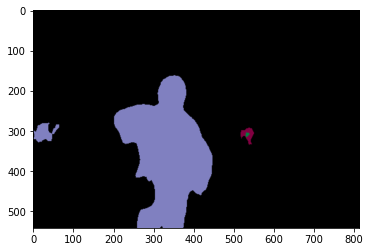

In [10]:
# 모델에서 나온 출력값 확인
plt.imshow(output)
plt.show()

In [11]:
segvalues

{'class_ids': array([ 0, 10, 12, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [13]:
# sefvalues의 class_ids를 통해 어떤 물체가 담겨있는지 확인 가능
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cow
dog
person


In [14]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
# PixelLib에 따르면 위와 같은 색을 사용했다고 함 
# 그럼 사람을 나타내는 15번째 색상은 무엇일까요?
colormap[15]

array([192, 128, 128])

In [16]:
# 사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 사용
# 주의: output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점, colormap은 RGB 순서이고요.
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함

seg_color = (128,128,192)

(542, 813)


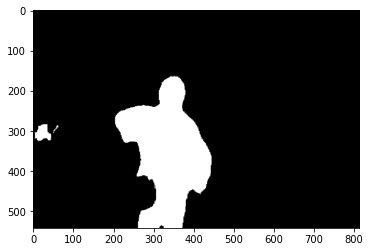

In [17]:
# seg_color로만 이루어진 마스크를 만들어 봅시다
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

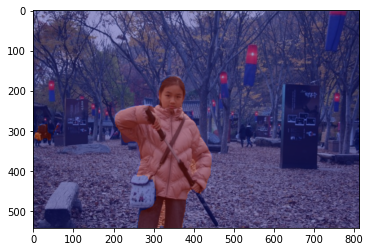

In [18]:
# 원래 이미지와 겹쳐 보아 세그멘터이션이 잘 되었는지 확인
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 흐리게 만들기

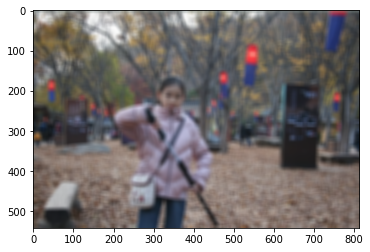

In [19]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐려진 이미지에 세그멘테이션 마스크를 이용해 배경만 추출

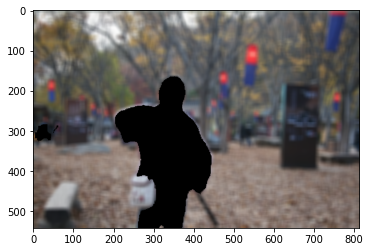

In [20]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)  # 이미지 반전 (배경 255, 사람 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # and연산으로 배경만 추출
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린 배경과 원본 영상 합성

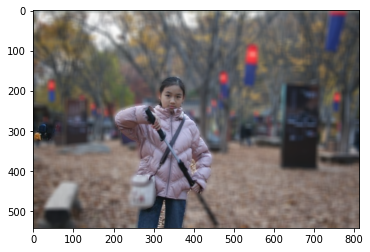

In [21]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 고양이

#### 고양이 대상 세그멘테이션

In [22]:
# seg_color 반환 함수
def get_colormap(label_name):
    # 아래 코드를 이해하지 않아도 좋습니다
    # PixelLib에서 그대로 가져온 코드입니다
    # 주목해야 할 것은 생상 코드 결과물이예요!
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    # colormap[:20]

    index = LABEL_NAMES.index(label_name)  # 데이터 라벨 인덱스
    seg_color = colormap[index].tolist()  # BGR
    seg_color = seg_color[::-1]  # BGR2RGB
    return seg_color  # RGB

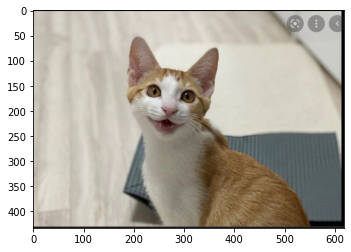

In [23]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig = cv2.imread(img_path3) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
# 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [25]:
# 모델에 이미지를 입힘
cat_segvalues, cat_output = model.segmentAsPascalvoc(img_path3)

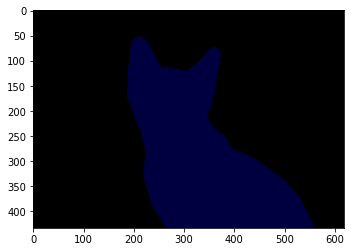

In [26]:
# 모델 출력값 확인
plt.imshow(cat_output)
plt.show()

In [27]:
# 구분한 segmentation
for class_id in cat_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


#### seg_color로만 구성된 마스크 형성

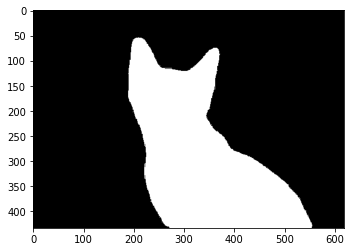

In [28]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_color = get_colormap('cat')
cat_seg_map = np.all(cat_output==seg_color, axis=-1)
plt.imshow(cat_seg_map, cmap='gray')
plt.show()

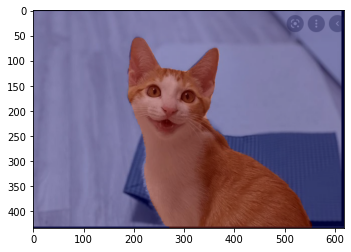

In [29]:
# 원본이미지와 겹쳐서 세그멘테이션 적용 확인
cat_img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
cat_img_mask = cat_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 흐리게 만들기

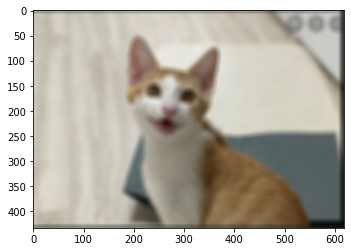

In [30]:
# 이미지 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
cat_img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

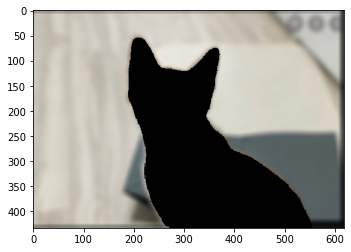

In [31]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린 배경과 원본 영상 합성

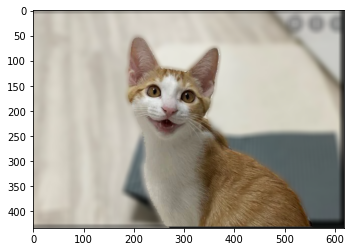

(433, 618, 3)


In [32]:
cat_img_concat = np.where(cat_img_mask_color==255, img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()
print(cat_img_concat.shape)

### 3. 배경전환 크로마키 사진

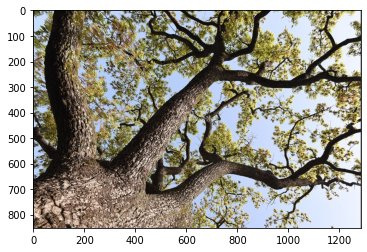

(852, 1283, 3)


In [33]:
# 배경 이미지 확인
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/tree.png'  
tree_img_orig = cv2.imread(img_path4) 
plt.imshow(cv2.cvtColor(tree_img_orig, cv2.COLOR_BGR2RGB))
plt.show()
print(tree_img_orig.shape)

In [34]:
# 고양이만 남기고 나머지는 0(검은색) 처리
cat_only_img_concat = np.where(cat_img_mask_color==255, img_orig, 0)

# 고양이 resize
h, w, c = cat_only_img_concat.shape
cat_img_resize = cv2.resize(cat_only_img_concat, (w//2, h//2), cv2.INTER_AREA)

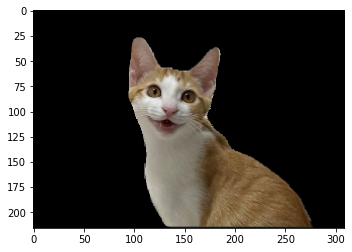

(216, 309, 3)


In [35]:
plt.imshow(cv2.cvtColor(cat_img_resize, cv2.COLOR_BGR2RGB))
plt.show()
print(cat_img_resize.shape)

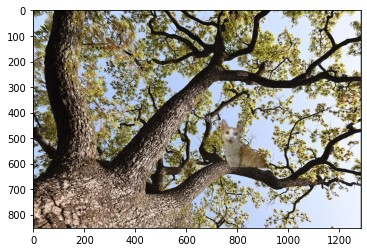

In [41]:
# 배경화면에 스티커 붙이는 방식의 화면 합성
back_img_show = tree_img_orig.copy()

refined_y = 400
refined_x = 640

alpha = 0.2  # 투명도
sticker_area = back_img_show[refined_y:refined_y+cat_img_resize.shape[0], refined_x:refined_x+cat_img_resize.shape[1]]
back_img_show[refined_y:refined_y +cat_img_resize.shape[0], refined_x:refined_x+cat_img_resize.shape[1]] = \
cv2.addWeighted(sticker_area, alpha, np.where(cat_img_resize==0,sticker_area,cat_img_resize).astype(np.uint8), 1-alpha, 0)  # 컬러 값 0(검은색)

plt.imshow(cv2.cvtColor(back_img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step 2. 사진에서 문제점 찾기 

#### 인물, 고양이 사진의 인식은 잘 되는 편이나, 다음과 같은 문제점 발생
* 배경과의 경계가 뚜렷하게 구분되지 않는 문제,
* 인물 사진의 일부로 가방이나, 다른 부착물이 같이 인식되지 않는 문제,
* 합성 사진에서 사진이 겹쳐있을 때 경계가 뜨거나 불명확해지는 문제

#### 노드에서는 이러한 문제점들의 해결방안으로 픽셀의 depth 정보를 넣어줌으로써 Semantic segmentation의 정확성을 높는 방법을 제시
* 3D camera 활용
* 구글의 struct2Depth 과 같이 소프트웨어적으로 접근하는 방법
* 적외선 카메라를 이용한 3d depth sensing 기술 이용
* 3D camera나 센서가 없다는 가정하에, 단일 이미지마다의 depth를 예측해주는 모델을 사용하여 depth를 측정  등

####  노드 제안 내용들은 구현하기 어려워, 물체의 경계를 잘 인식하지 못하고 있는 것으로 가정, 이미지의 경계를 좀 더 명확히 하여 segmentation 정확도를 높이는 방안을 시도해 봄

In [18]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


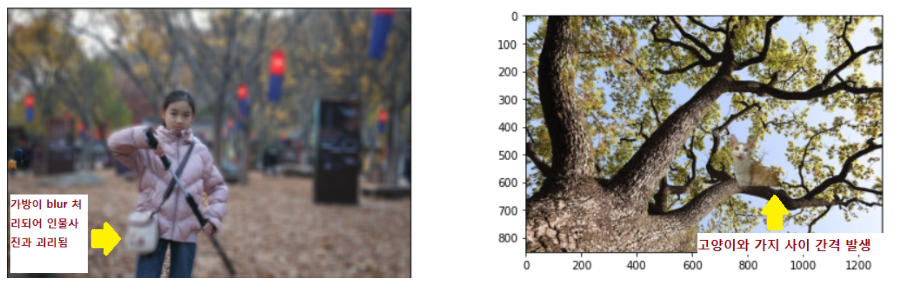

In [44]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/temp_캡처_표시.png'  
img_orig2 = cv2.imread(img_path2) 
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_concat.png'  
img_orig3 = cv2.imread(img_path3) 

plt.figure(figsize=(16,24))

plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.rc('axes', titlesize=20)
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.rc('axes', titlesize=20)
plt.axis('off')

plt.show()

### Step 3. 해결 방법을 제안해 보기
<br>
 1) 경계선 구분을 더 잘하기 위해 이미지 대조색상 강조    <br>
 2) 경계선 검출사진 활용

 : 여전히 해결이 안됨, 가방부분 인물과 괴리
 

##### 이미지 대조 색상 강조한 사진 활용

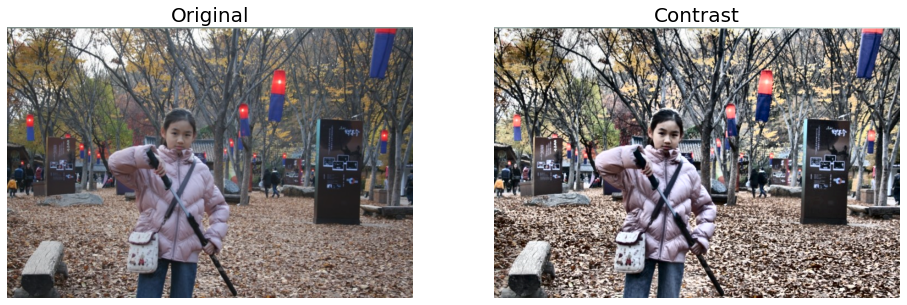

In [45]:
# 이미지 대조 색상 강조하기 https://ansan-survivor.tistory.com/311

''' 함수) 이미지를 더 선명하게 Contrast(대조) 기법을 적용시킴.
param : 컬러 이미지
return : 대조된 이미지
'''

def img_Contrast(img):
    # -----Converting image to LAB Color model-----------------------------------
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # -----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    
    # -----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # -----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl, a, b))
    
    # -----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

img = cv2.imread(os.getenv('HOME')+'/aiffel/human_segmentation/images/m_image.png', cv2.COLOR_BGR2GRAY)
c_img = img_Contrast(img)

plt.figure(figsize=(16,24))

plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.rc('axes', titlesize=20)
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))
plt.title("Contrast")
plt.rc('axes', titlesize=20)
plt.axis('off')

plt.show()


In [47]:
plt.imsave(os.getenv('HOME')+'/aiffel/human_segmentation/images/m_image_contrast.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

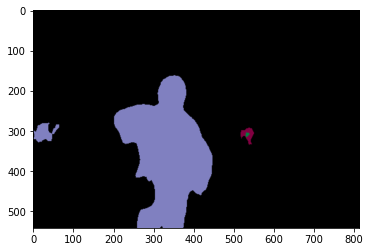

In [49]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/m_image_contrast.png'  

segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

# 여전히 해결이 안됨, 가방부분 인물과 괴리됨


##### 엣지 검출 사진 활용

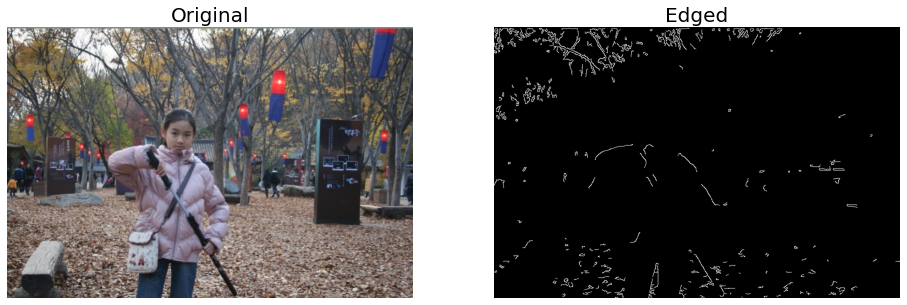

In [50]:
# 캐니 엣지 적용
edged = cv2.Canny(img, 300, 600)  # 하단 임계값과 상단 임계값은 실험적으로 결정하기

plt.figure(figsize=(16,24))

plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.rc('axes', titlesize=20)
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.title("Edged")
plt.rc('axes', titlesize=20)
plt.axis('off')

plt.show()


In [51]:
plt.imsave(os.getenv('HOME')+'/aiffel/human_segmentation/images/m_image_edge.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

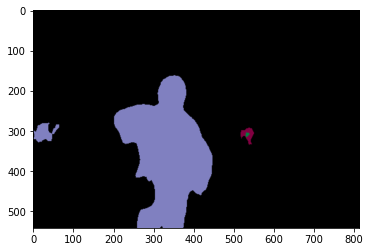

In [52]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/m_image_edge.png'  

segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

# 여전히 해결이 안됨, 가방부분 인물과 괴리됨

### [ 회  고 ]
<br>
* 단순해 보이는 합성사진에도 세부적으로 어려운 난관들이 숨어있음: 쉽게 되는 일은 없다   <br>
* 특히 인물 사진은 저작권 문제로 조심스러워 가족사진을 활용하게 됨.  다양한 이미지의 효과 테스트 필요할 것 같다.   <br>
* OpenCV에 다양한 기능들이 있음을 알게 되어, 좀 더 공부해야 할 것 같다.(matplotlib, seaborn, plotly,PIL,Opencv 등등 왜 이렇게 많지?) <br>  
* 이전까지 계속 Colab에서 작성해 왔는데, Colab 에러가 해결되지 않아 LMS에서 진행하게 되었다.(모듈의 에러 발생 해결과제 계속될 것 같음)  <br> 
* 이미지 처리에 numpy 모듈이 많이 사용되는 점이 인상적이다. (어짜피 컴퓨터는 이미지를 숫자로 인식한다는 점)   <br>

#### < 참고 자료 >
* https://ansan-survivor.tistory.com/311   
* https://docs.opencv.org/4.x/d7/da8/tutorial_table_of_content_imgproc.html